In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.cm as cm
from matplotlib.colors import rgb2hex
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import snowflake.connector
import tqdm
import datetime
import timedelta
from time import time

In [2]:
matplotlib.rcParams['figure.figsize'] = (13,8)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['axes.labelsize'] = 15
matplotlib.rcParams['ytick.major.size'] = 10
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 13
%config InlineBackend.figure_format = 'retina'

In [3]:
import os
os.chdir('/Users/jehlokhande/Desktop/Spotify/MyData')

### Load Data and Feature Engineering

In [4]:
stream = pd.read_json('StreamingHistory0.json')
stream.columns = stream.columns.str.replace(' ', '_').str.lower()
stream['endtime'] = pd.to_datetime(stream['endtime']) 
stream['endtime'] = stream['endtime'].dt.tz_localize('UTC')
stream['endtime'] = stream['endtime'].dt.tz_convert('America/Los_Angeles')
stream['endtime'] = stream['endtime'].dt.tz_localize(None)
stream.head()

,endtime,artistname,trackname,msplayed
0,2019-12-02 07:22:00,Tanishk Bagchi,Makhna,10846
1,2019-12-02 07:25:00,Tanishk Bagchi,Makhna,10087
2,2019-12-02 07:25:00,Tanishk Bagchi,Makhna,174703
3,2019-12-02 07:25:00,Anne-Marie,2002,10087
4,2019-12-02 07:25:00,Selena Gomez,Back To You,0


In [5]:
stream['day'] = stream['endtime'].dt.day_name() 
stream['weekday'] = stream['endtime'].dt.weekday
stream['weekend_flag'] = stream['weekday'].apply(lambda x: 1 if x>=5 else 0)
stream['date'] = pd.to_datetime(stream['endtime'].dt.date)

stream['week'] = stream['endtime'].dt.weekofyear
stream['week_date'] = stream['date'].apply(lambda x: x - pd.DateOffset(int(x.weekday())))

stream['month'] = stream['endtime'].dt.month
stream['month_name'] = stream['endtime'].dt.month_name()
stream['day_num'] = stream['date'].dt.day
stream['month_date'] = stream['date'].apply(lambda x: x - pd.DateOffset(int(x.day)-1))

stream['hour'] = stream['endtime'].dt.hour

/Users/jehlokhande/.pyenv/versions/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [6]:
stream['time_min'] = stream['msplayed']/1000/60

stream['wfh_flag'] = stream['date'].apply(lambda x: 1 if str(x)>= '2020-03-15' else 0 )

In [7]:
# stream.to_csv('spotify_data.csv')
stream.head()

,endtime,artistname,trackname,msplayed,day,weekday,weekend_flag,date,week,week_date,month,month_name,day_num,month_date,hour,time_min,wfh_flag
0,2019-12-02 07:22:00,Tanishk Bagchi,Makhna,10846,Monday,0,0,2019-12-02,49,2019-12-02,12,December,2,2019-12-01,7,0.180767,0
1,2019-12-02 07:25:00,Tanishk Bagchi,Makhna,10087,Monday,0,0,2019-12-02,49,2019-12-02,12,December,2,2019-12-01,7,0.168117,0
2,2019-12-02 07:25:00,Tanishk Bagchi,Makhna,174703,Monday,0,0,2019-12-02,49,2019-12-02,12,December,2,2019-12-01,7,2.911717,0
3,2019-12-02 07:25:00,Anne-Marie,2002,10087,Monday,0,0,2019-12-02,49,2019-12-02,12,December,2,2019-12-01,7,0.168117,0
4,2019-12-02 07:25:00,Selena Gomez,Back To You,0,Monday,0,0,2019-12-02,49,2019-12-02,12,December,2,2019-12-01,7,0.000000,0


### EDA

1.   Listening time over weeks
2.   Top artists by week over time
3. Top songs by week over time
4. Number of songs by week over time
5. Listening time by day of week
6. ... some more ideas



In [151]:
### Listening time over the year

Text(0.5, 0, 'Week')

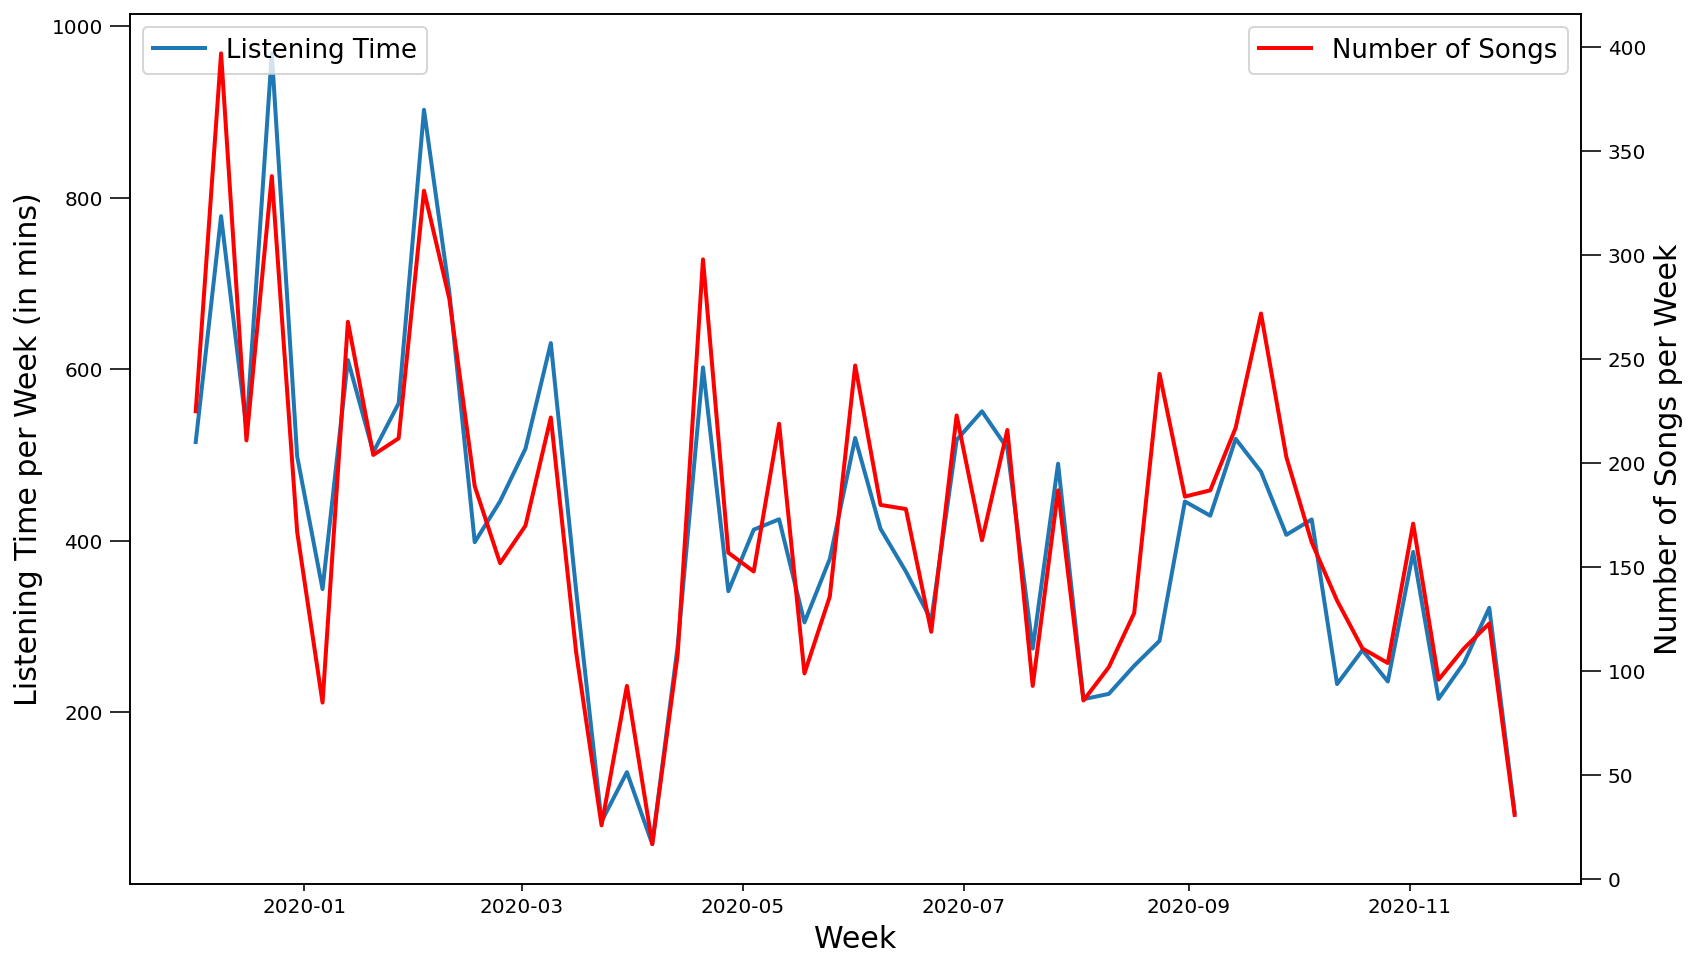

In [ ]:
weekly_stream = stream.groupby(by = ['week', 'week_date'], as_index = False).agg({'time_min':'sum', 'trackname':'count'})
weekly_stream.head()

ax1 = sns.lineplot(data = weekly_stream, x = 'week_date', y = 'time_min', label='Listening Time')
ax2 = plt.twinx()
sns.lineplot(data=weekly_stream, x = 'week_date', y = 'trackname', color="r", ax=ax2, label='Number of Songs')


ax1.legend(loc = 'upper left')
ax2.legend(loc='upper right')
ax1.set_ylabel('Listening Time per Week (in mins)')
ax2.set_ylabel('Number of Songs per Week')
ax1.set_xlabel('Week')


In [ ]:
hourly_stream = stream.groupby(by = ['date','hour'], as_index = False).agg({'time_min':'sum', 'trackname':'count'})
hourly_stream['hour_2'] = np.round(hourly_stream['hour']/4)*4
hourly_stream.head()

,date,hour,time_min,trackname,hour_2
0,2019-12-02,7,37.150900,22,8.0
1,2019-12-02,8,36.915100,11,8.0
2,2019-12-02,15,9.962317,4,16.0
3,2019-12-02,16,12.160950,5,16.0
4,2019-12-03,8,10.263933,14,8.0


/Users/jehlokhande/.pyenv/versions/py36/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/jehlokhande/.pyenv/versions/py36/lib/python3.6/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.25 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/Users/jehlokhande/.pyenv/versions/py36/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) o

([<matplotlib.axis.XTick at 0x13dad90b8>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

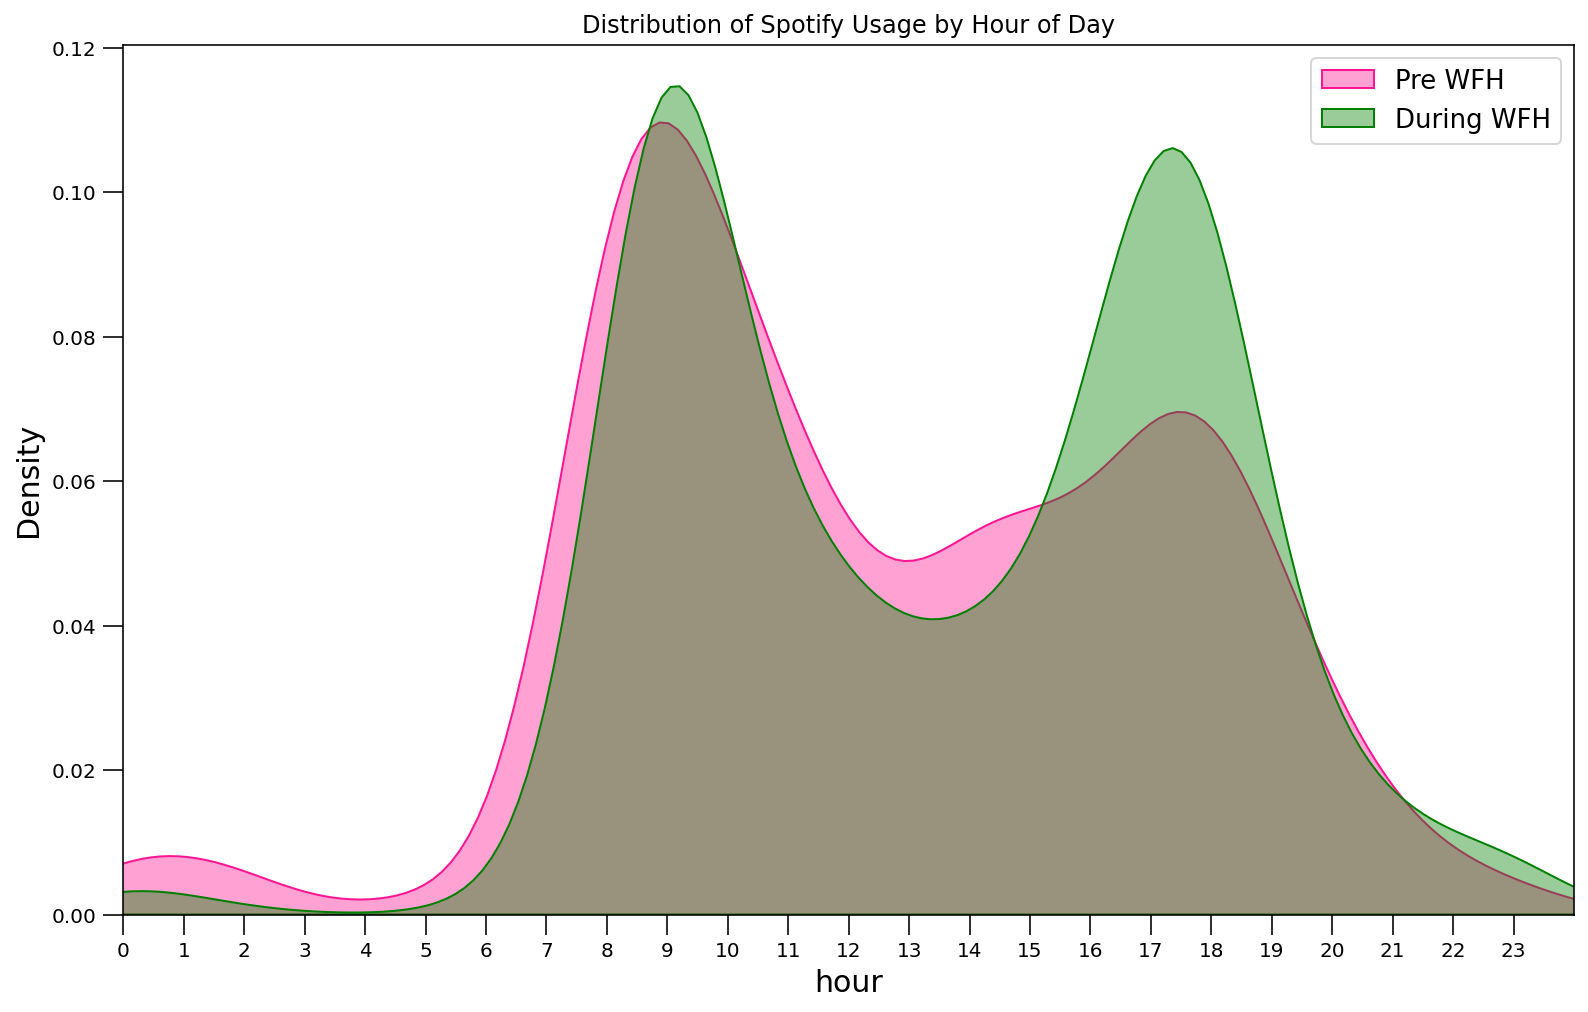

In [44]:
### Histogram of listening time across hour of day

sns.distplot(stream.query('wfh_flag==0')['hour'], label = 'Pre WFH', color = 'deeppink',kde_kws={'bw':0.25, 'fill':True, 'alpha':0.4}, hist = False)
sns.distplot(stream.query('wfh_flag==1')['hour'], label = 'During WFH', color = 'green', kde_kws={'bw':0.25, 'fill':True, 'alpha':0.4}, hist = False)
plt.legend()
plt.title('Distribution of Spotify Usage by Hour of Day')
plt.xlim(0,24)
plt.xticks(np.arange(0,24,1))

/Users/jehlokhande/.pyenv/versions/py36/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/jehlokhande/.pyenv/versions/py36/lib/python3.6/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.25 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/Users/jehlokhande/.pyenv/versions/py36/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) o

([<matplotlib.axis.XTick at 0x13eeda7f0>,
 [Text(0, 0, 'Mon'),
  Text(1, 0, 'Tue'),
  Text(2, 0, 'Wed'),
  Text(3, 0, 'Thu'),
  Text(4, 0, 'Fri'),
  Text(5, 0, 'Sat'),
  Text(6, 0, 'Sun')])

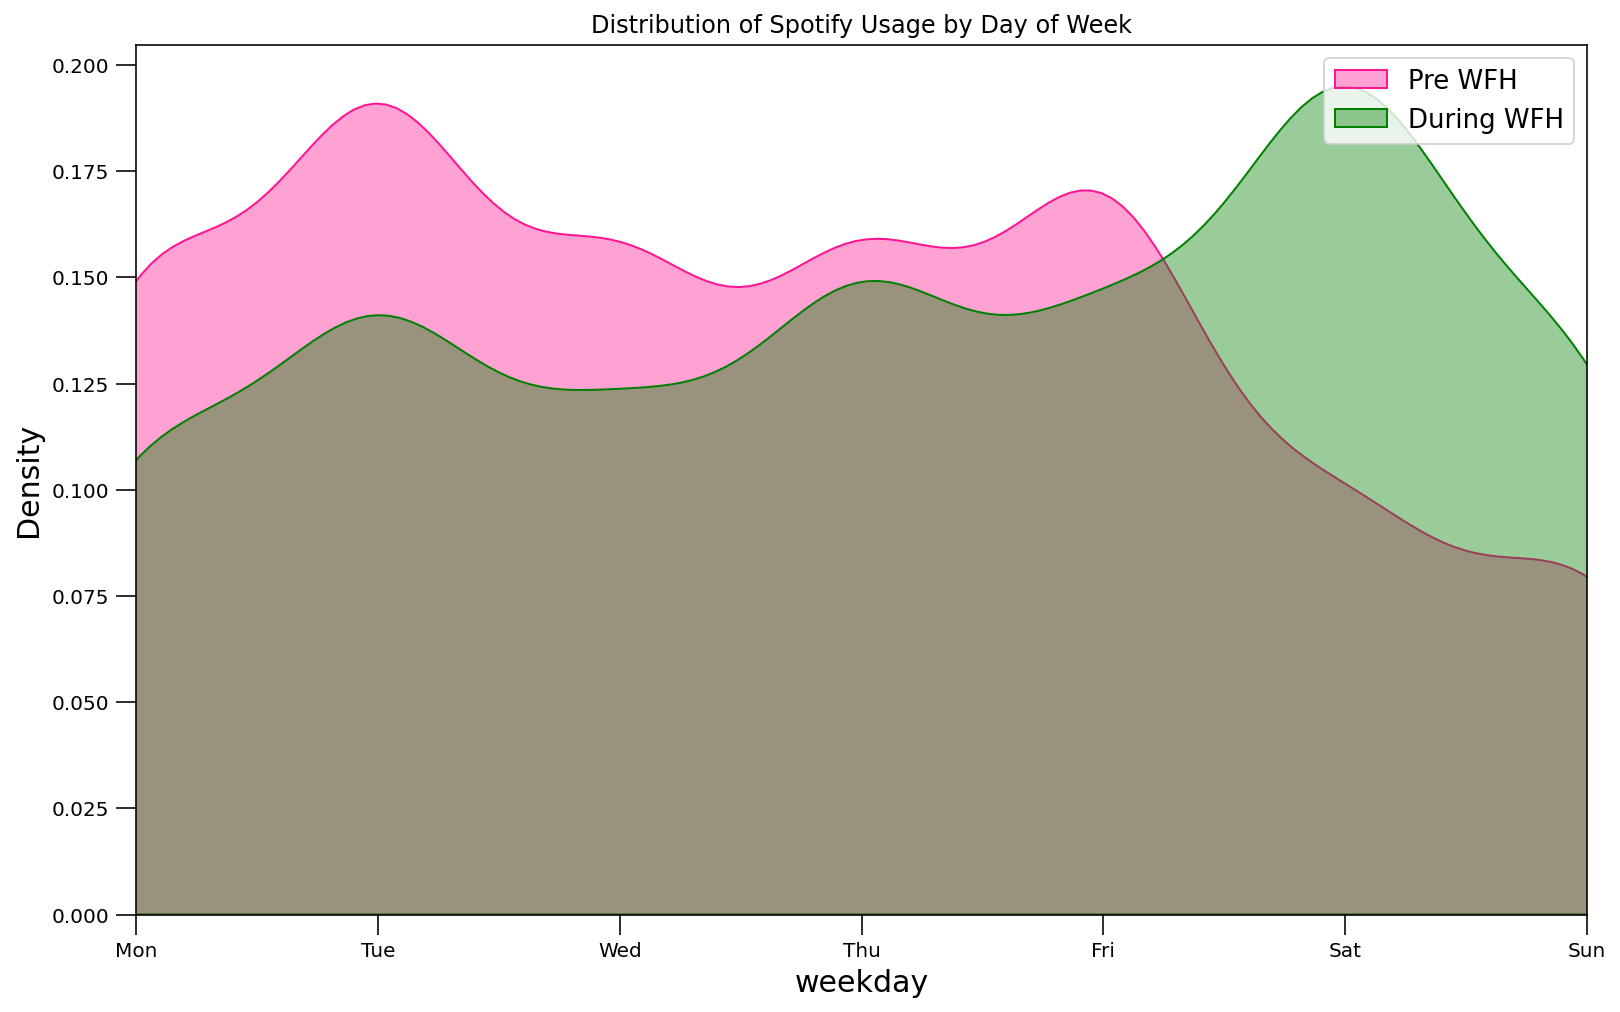

In [ ]:
### Histogram of listening time across day of week

sns.distplot(stream.query('wfh_flag==0')['weekday'], label = 'Pre WFH', color = 'deeppink', bins = 7, kde_kws={'bw':0.25, 'fill':True, 'alpha':0.4}, hist = False)
sns.distplot(stream.query('wfh_flag==1')['weekday'], label = 'During WFH', color = 'green', bins = 7, kde_kws={'bw':0.25, 'fill':True, 'alpha':0.4}, hist = False)
plt.legend()
plt.title('Distribution of Spotify Usage by Day of Week')
plt.xlim(0,6)

plt.xticks(np.arange(7), ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'))

In [45]:
daily_stream = stream.groupby(by = ['date', 'wfh_flag'], as_index = False).agg({'time_min':'sum', 'trackname':'count'})
daily_stream.head()

,date,wfh_flag,time_min,trackname
0,2019-12-02,0,96.189267,42
1,2019-12-03,0,27.461867,15
2,2019-12-04,0,54.550350,26
3,2019-12-05,0,46.344883,20
4,2019-12-06,0,218.395467,83


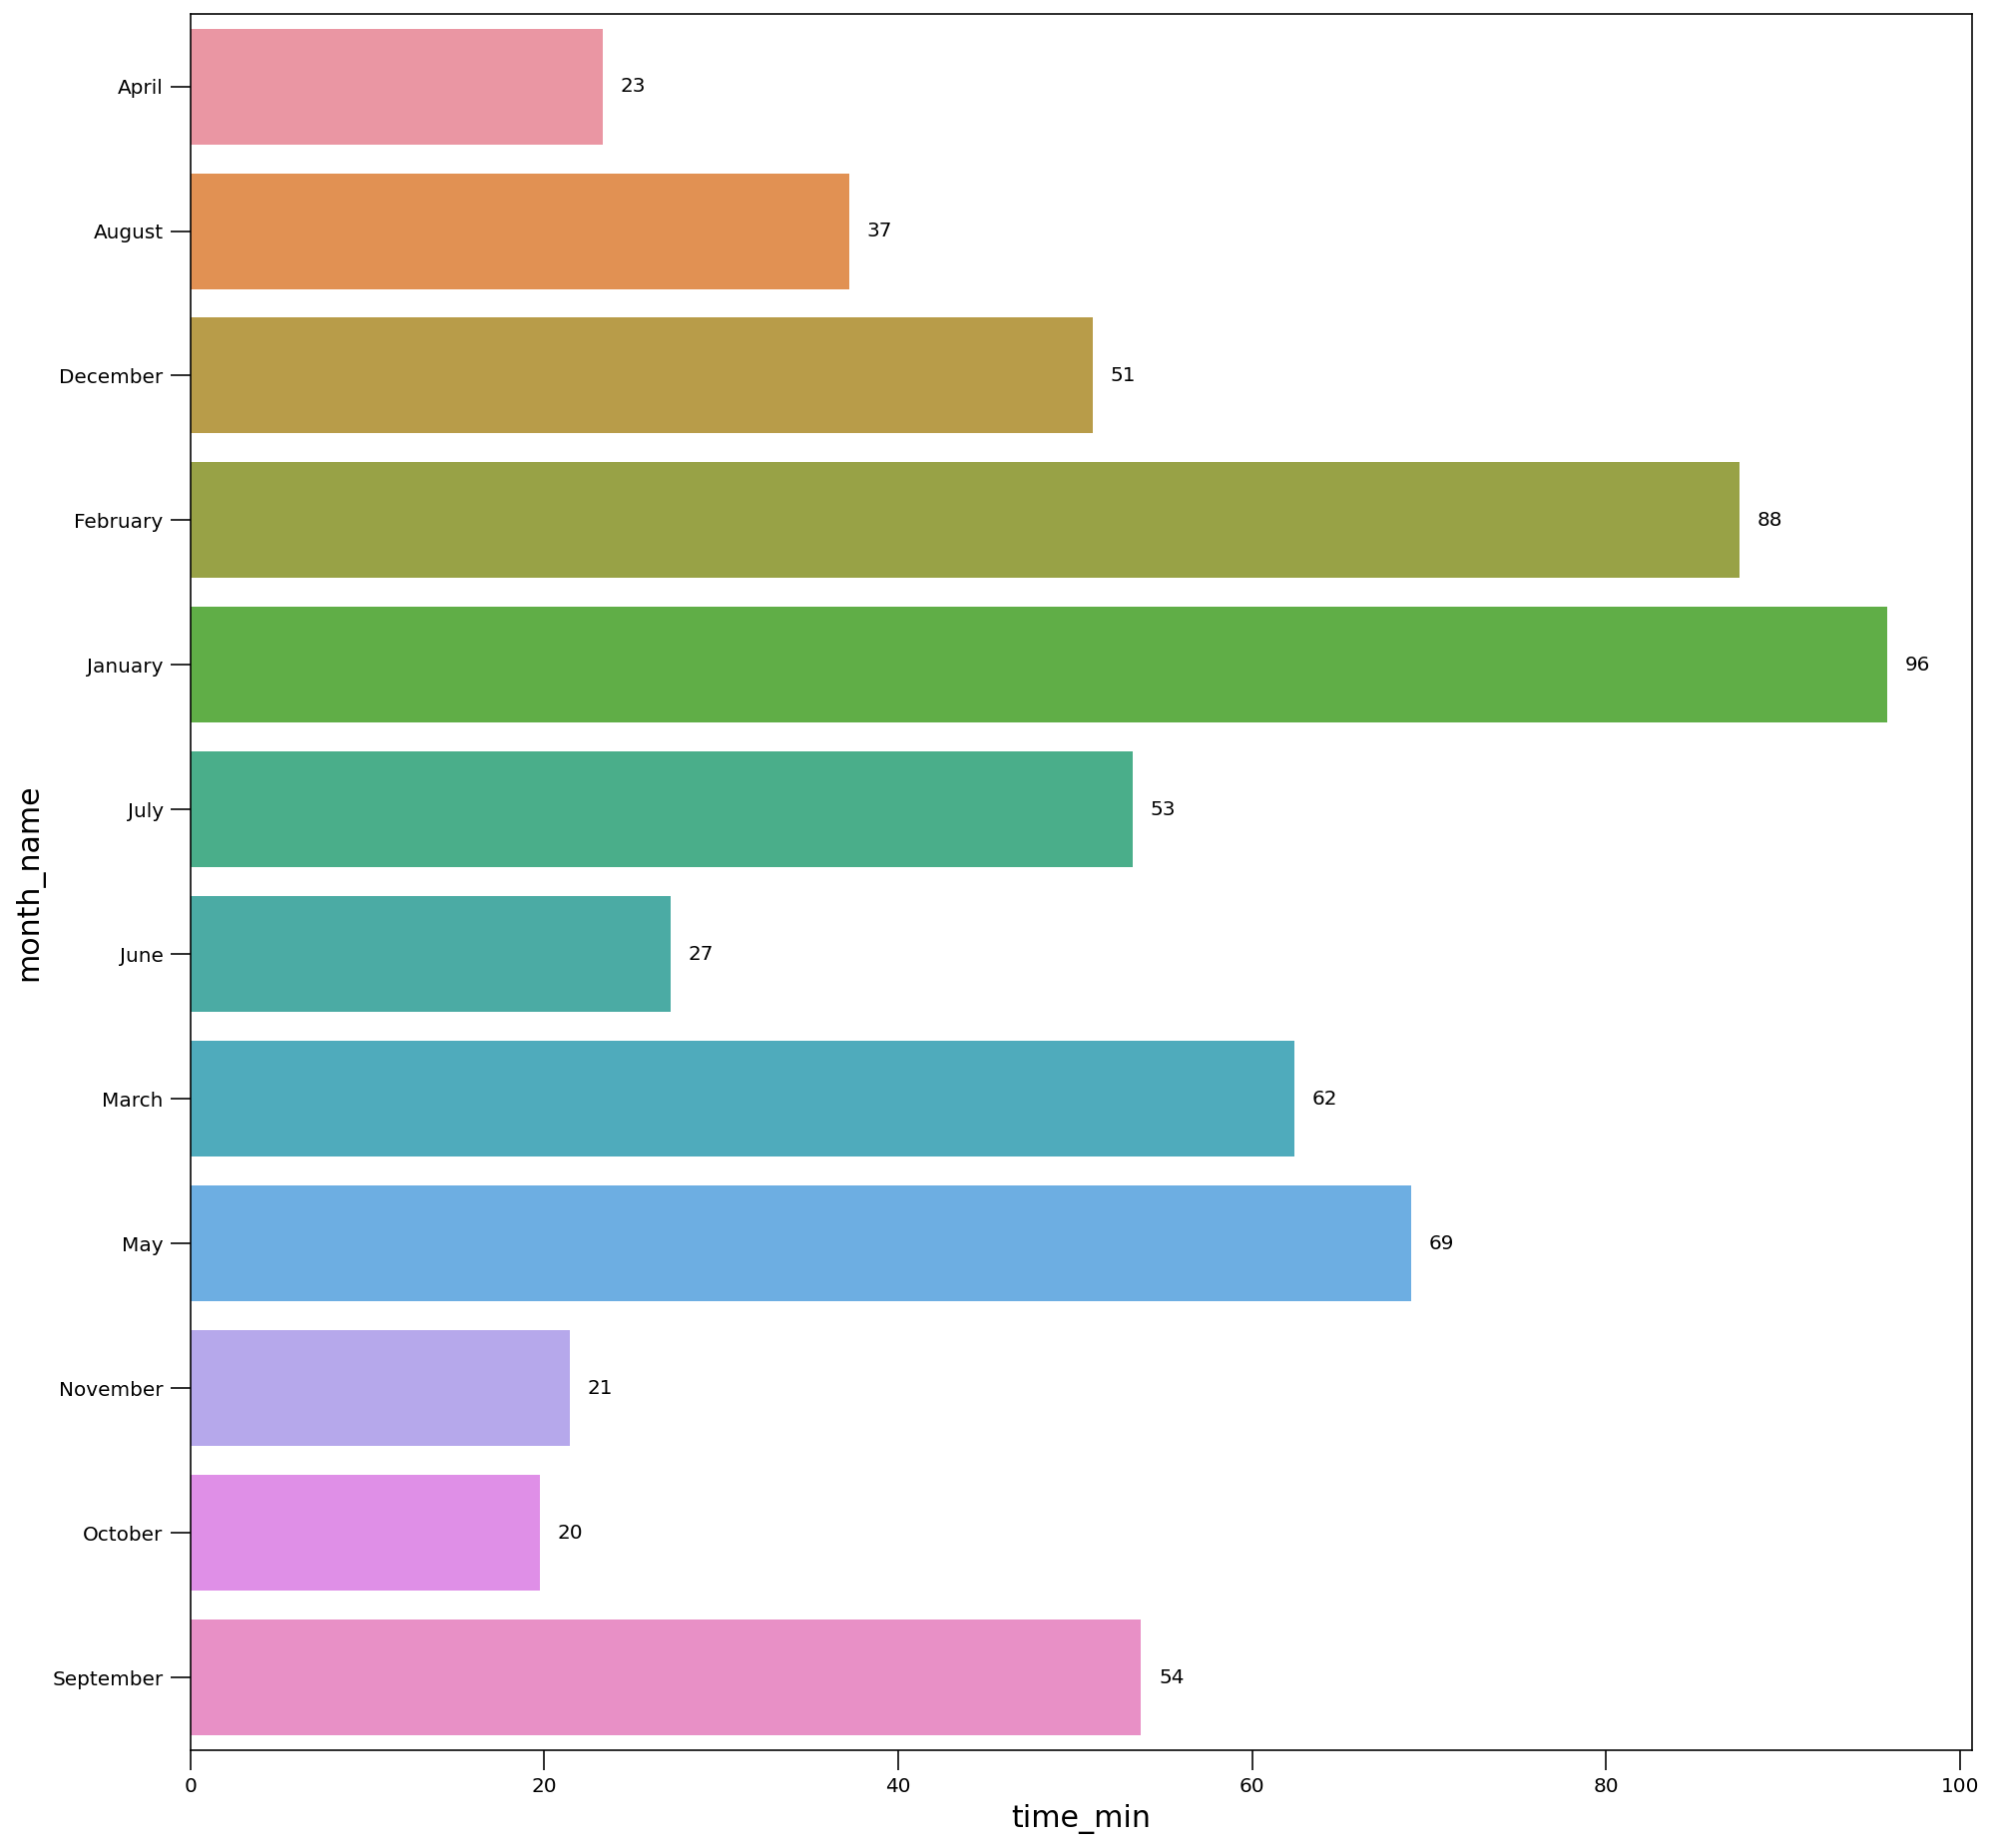

In [33]:
#Top streams every month

plt.figure(figsize = (16,16))
monthly_stream = stream.groupby(by = ['month_name', 'month_date', 'trackname'], as_index = False).agg({'time_min':'sum', 'endtime':'count'})
monthly_stream.head()

monthly_stream_max = monthly_stream[monthly_stream.groupby(by = ['month_name', 'month_date'])['time_min'].transform(max) == monthly_stream['time_min']]
ax = sns.barplot(data = monthly_stream_max, y = 'month_name', x = 'time_min', orient = 'h', ci = False)


# label each bar in barplot
for p in ax.patches:
 height = p.get_height() # height of each horizontal bar is the same
 width = p.get_width() # width (average number of passengers)
 # adding text to each bar
 ax.text(x = width+1, # x-coordinate position of data label, padded 3 to right of bar
 y = p.get_y()+(height/2), # # y-coordinate position of data label, padded to be in the middle of the bar
 s = '{:.0f}'.format(width), # data label, formatted to ignore decimals
 va = 'center') # sets vertical alignment (va) to center

Text(0.5, 53.5, 'During WFH')

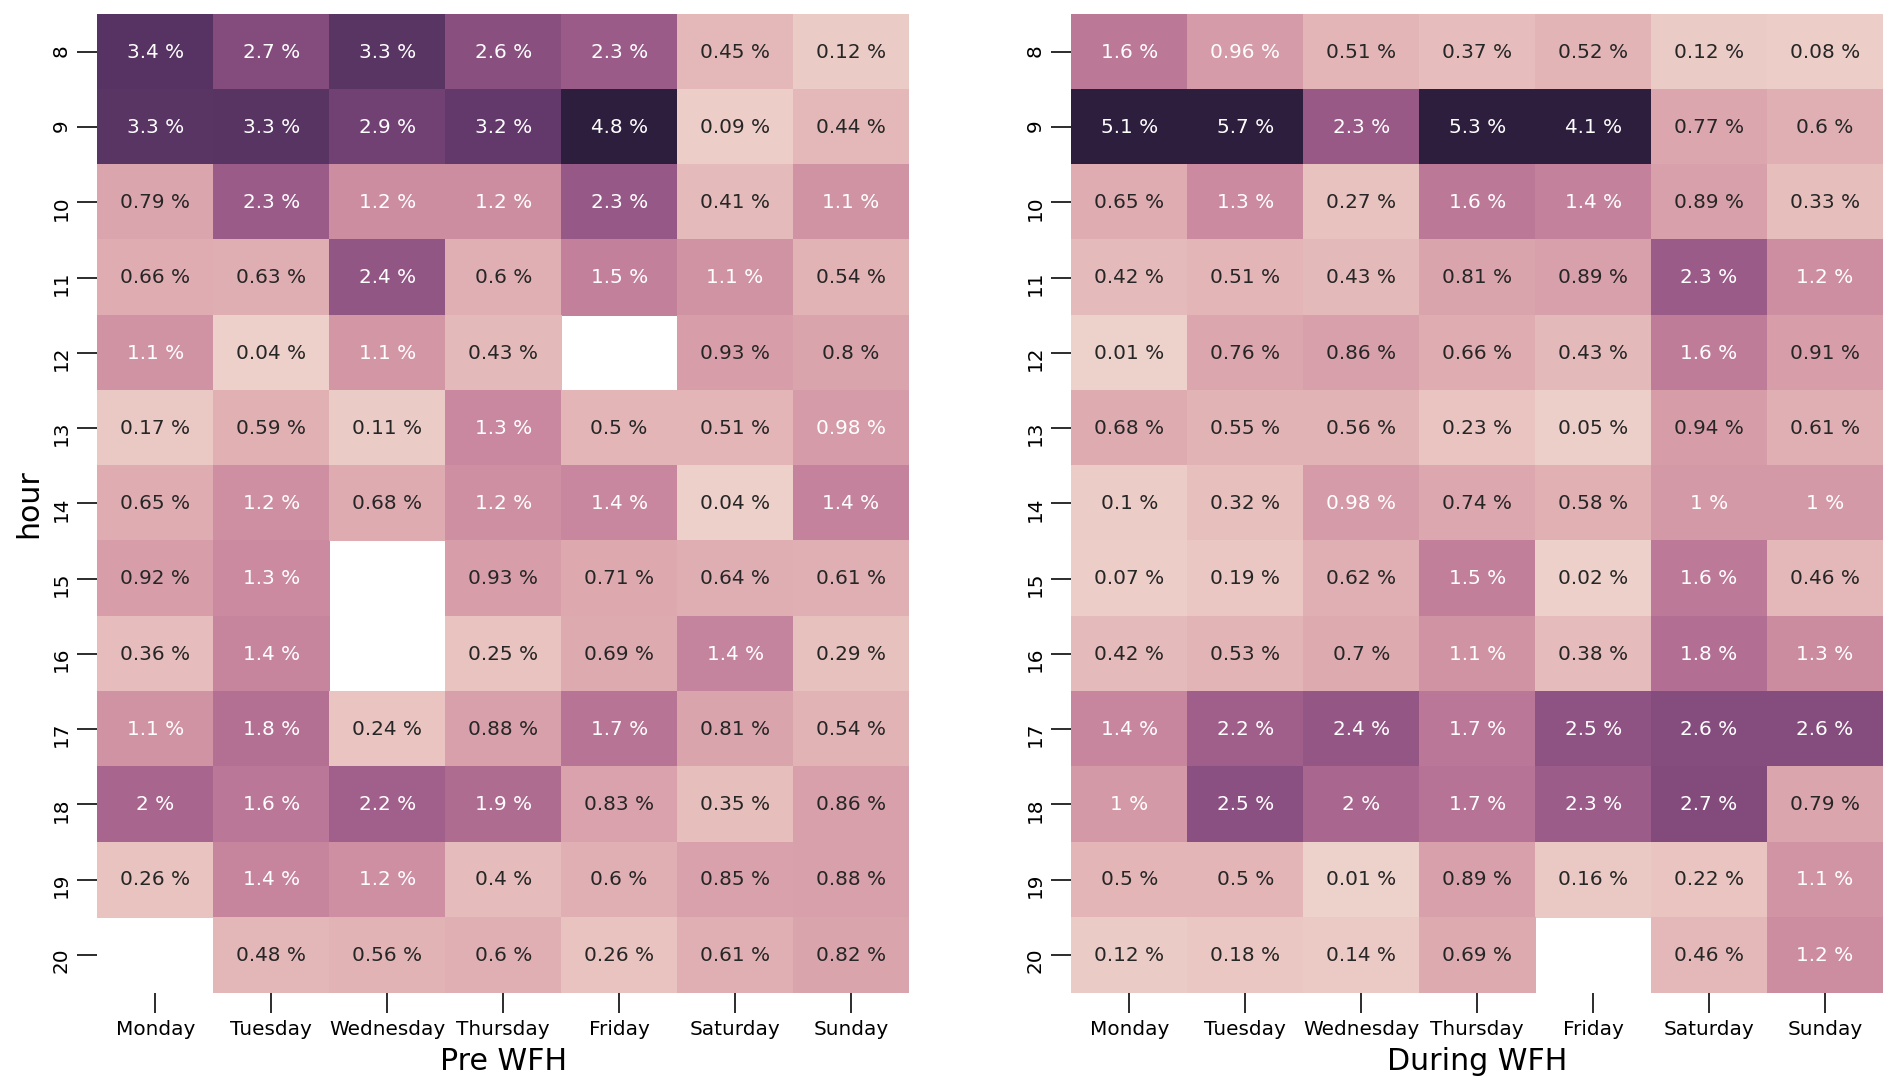

In [140]:
day_hour_pre = stream.query('hour >= 8 and hour <= 20 and wfh_flag == 0').groupby(by = ['wfh_flag', 'day', 'hour'], as_index = False).agg({'time_min':'sum'})
day_hour_pre['perc_time'] = np.round(100*day_hour_pre['time_min']/np.sum(day_hour_pre['time_min']),2)
day_hour_pre.drop(columns = ['time_min'], inplace = True)
# day_hour_pre.head()

day_hour_during = stream.query('hour >= 8 and hour <= 20 and wfh_flag == 1').groupby(by = ['wfh_flag', 'day', 'hour'], as_index = False).agg({'time_min':'sum'})
day_hour_during['perc_time'] = np.round(100*day_hour_during['time_min']/np.sum(day_hour_during['time_min']),2)
day_hour_during.drop(columns = ['time_min'], inplace = True)
# day_hour_during.head()

##Heatmap of categories over weekday
plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize = (16,9))
plt.subplot(1,2,1)
result = day_hour_pre.query('wfh_flag == 0').pivot(index='hour', columns='day', values='perc_time')[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
ax = sns.heatmap(result, cmap = sns.cubehelix_palette(as_cmap=True), vmin=0, vmax=4, annot=True, annot_kws={"size": 10}, cbar = False)
for t in ax.texts: t.set_text(t.get_text() + " %")
plt.xlabel('Pre WFH')
# a2.set(xlabel='Category', ylabel='Day of the Week (0 - Mon, 6 - Sun)')
# plt.show(a2)

plt.subplot(1,2,2)
result = day_hour_during.query('wfh_flag == 1').pivot(index='hour', columns='day', values='perc_time')[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
ax2 = sns.heatmap(result, cmap = sns.cubehelix_palette(as_cmap=True), vmin=0, vmax = 4, annot=True, annot_kws={"size": 10}, cbar = False)
for t in ax2.texts: t.set_text(t.get_text() + " %")
plt.ylabel('')
plt.xlabel('During WFH')
# a2.set(xlabel='Category', ylabel='Day of the Week (0 - Mon, 6 - Sun)')


<AxesSubplot:xlabel='trackname', ylabel='artistname'>

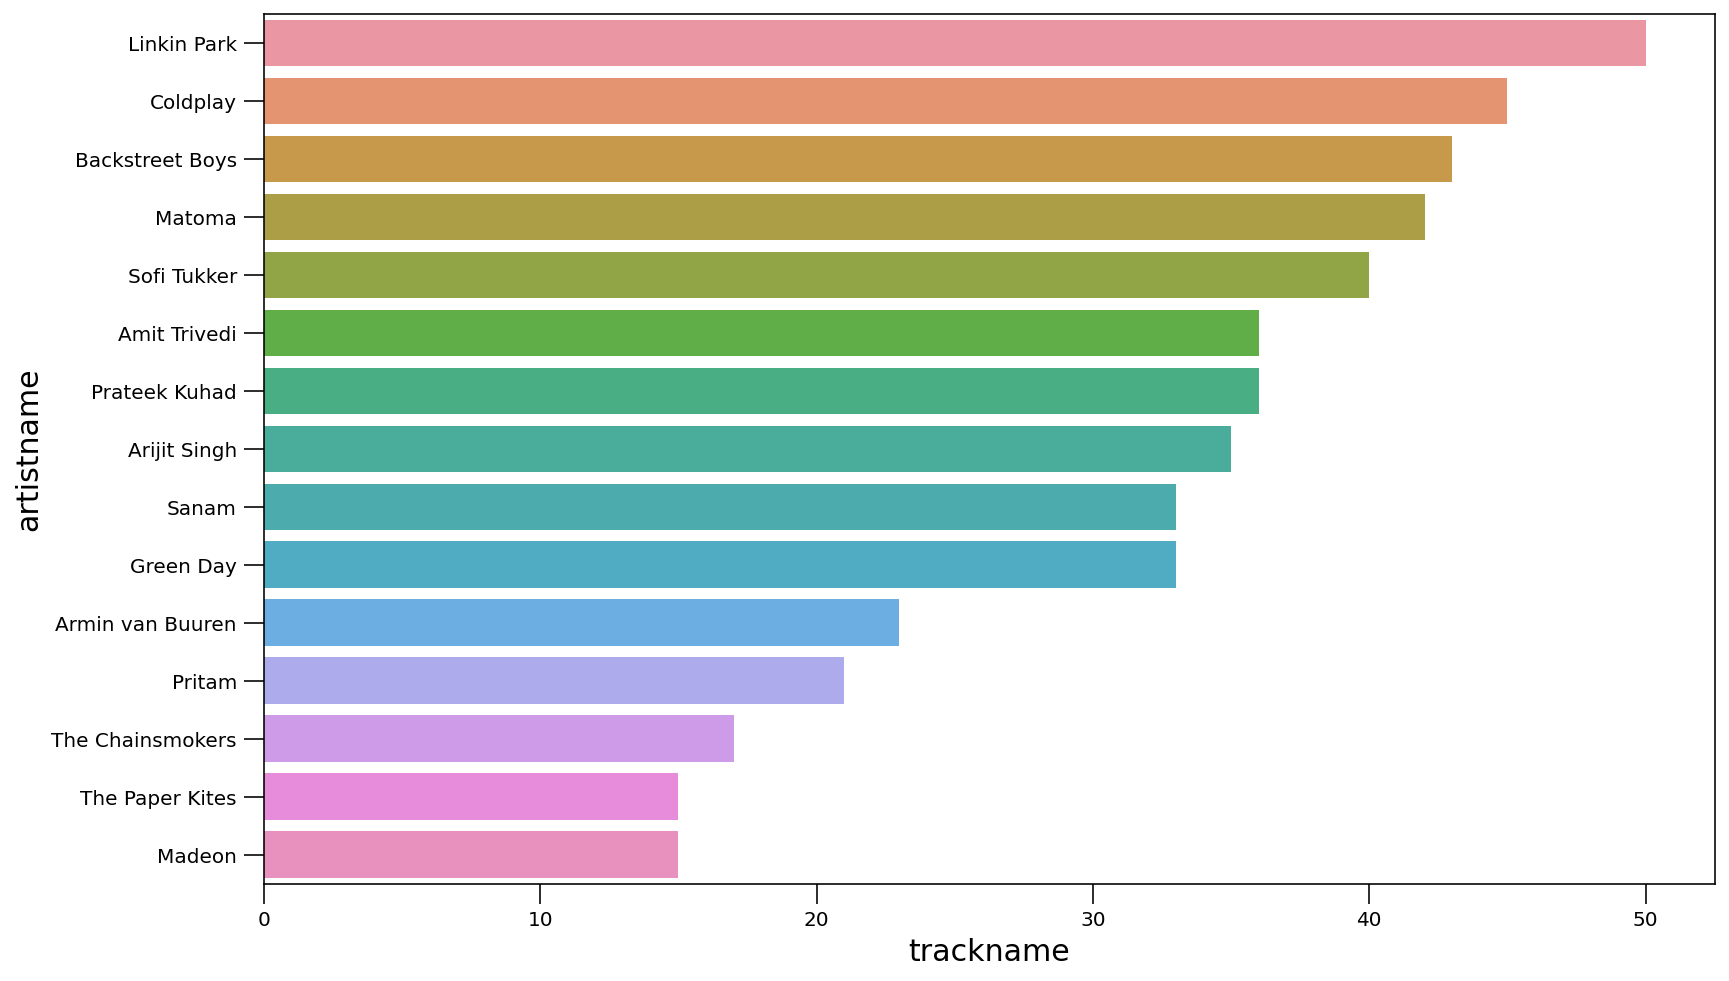

In [150]:
#Songs per artist

sns.barplot(data = stream.groupby(by = 'artistname', as_index=False).agg({'trackname':'nunique'}).sort_values(by = 'trackname', ascending=False)[:15], y = 'artistname', x = 'trackname', orient = 'h')